# Literature Sources for the Equations

[WSL Swiss Federal Institute for Forest, Snow, and Landscape Research Fire Weather Indices Wiki](https://wikifire.wsl.ch/tiki-index908f.html?page=Keetch-Byram+drought+index#:~:text=Formula,Keetch%20and%20Byram%20(1968).)

[Alexander, 1990: Computer calculation of the Keetch-Byram drought index - programmers beware](https://people.atmos.ucla.edu/ycao/papers/Computer%20Calculation%20of%20the%20Keetch-Byram%20Drought%20Index-Programmers%20Beware!.pdf)

[Keetch and Byram, 1968: A drought index for forest fire control, USDA FSRP SE-38](https://research.fs.usda.gov/treesearch/40)

[Wildland Fire Assessment System](https://www.wfas.net/index.php?option=com_content&view=article&id=86&Itemid=487#:~:text=Keetch%20and%20Byram%20(1968)%20designed,duff%20and%20upper%20soil%20layers.)

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

# import dask
# import dask.array as da

import matplotlib.pyplot as plt

In [2]:
# file paths
pr_file = r'D://data/nclimgrid_daily/prcp_nClimGridDaily_1951-2024_USsouth.nc'
tmax_file = r'D://data/nclimgrid_daily/tmax_nClimGridDaily_1951-2024_USsouth.nc'

# pr_file = r'E://data/nclimgrid_daily/prcp_nClimGridDaily_1951-2024_USsouth.nc'
# tmax_file = r'E://data/nclimgrid_daily/tmax_nClimGridDaily_1951-2024_USsouth.nc'

# Steps (starting with single cell calculation)

1) KBDI initialization: find the starting day of the calculation
    - find when the running sum of precip over a 1 week period is at least 152mm (6 inches)
    - the starting day for calculating KBDI is the next day
2) calculate the number of consecutive days with rain (rr) for the whole timeseries so we can accurately calculate Pnet
3) calculate Pnet at each time using the description in Keetch and Byram
4) calculate Q of t0 using KBDI of t-1 = 0
5) calculate KBDI

# 1) KBDI Initialization date

Finding the first possible day at each grid where we can set the initial value of KBDI to zero. This requires a preceding wet period where at least 152mm/6inches of precip falls with 1 week.

In [3]:
# load 5 years of precip data at a single grid, limit precision per metadata, and convert units

year_start='1951'
year_end='1955'
lat = 32
lon = -90

pr=xr.open_dataset(pr_file).prcp.sel(time=slice(year_start,year_end)).sel(lat=lat,lon=lon, method='nearest').round(2).load()

# pr = pr / 25.4
# pr_attrs = {'standard_name':'precipitation','long_name':'Precipitation, daily total','units':'inches/day'}
# pr.attrs = pr_attrs

pr

<xarray.DataArray 'prcp' (time: 1826)> Size: 7kB
array([ 0.  ,  7.73, 24.83, ...,  0.  ,  0.  ,  0.  ],
      shape=(1826,), dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 15kB 1951-01-01 1951-01-02 ... 1955-12-31
    lat          float32 4B 32.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0
Attributes:
    id:                /workspace/home2/home/imke.durre/active/live/products/...
    long_name:         Precipitation, daily total
    valid_max:         2000.0
    standard_name:     precipitation_amount
    naming_authority:  gov.noaa.ncei
    source:            GHCN-Daily CSV files 
    comment:           Values should be rounded to the nearest hundredth. Eac...
    units:             mm/day
    reference:         https://doi.org/10.1175/JTECH-D-22-0024.1
    valid_min:         0.0
    metadata_link:     https://doi.org/10.25921/c4gt-r169

In [4]:
# determine if the grid is land or water

landmask=1 if np.isfinite(pr.mean()) else 0
landmask

1

In [5]:
# create an integer time index coordinate since datetimes will give us some trouble

time_index=np.arange(0,len(pr.time)).astype('int')
pr.coords['time_index']=('time',time_index)

pr

<xarray.DataArray 'prcp' (time: 1826)> Size: 7kB
array([ 0.  ,  7.73, 24.83, ...,  0.  ,  0.  ,  0.  ],
      shape=(1826,), dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 15kB 1951-01-01 1951-01-02 ... 1955-12-31
    lat          float32 4B 32.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0
    time_index   (time) int64 15kB 0 1 2 3 4 5 ... 1820 1821 1822 1823 1824 1825
Attributes:
    id:                /workspace/home2/home/imke.durre/active/live/products/...
    long_name:         Precipitation, daily total
    valid_max:         2000.0
    standard_name:     precipitation_amount
    naming_authority:  gov.noaa.ncei
    source:            GHCN-Daily CSV files 
    comment:           Values should be rounded to the nearest hundredth. Eac...
    units:             mm/day
    reference:         https://doi.org/10.1175/JTECH-D-22-0024.1
    valid_min:         0.0
    metadata_link:     https://doi.org/10.25921/c4gt-r169

In [6]:
# sum precip in 7 day rolling windows

ndays=7
pr_thresh=152 # mm

pr_weeksum=pr.rolling(time=ndays,min_periods=ndays,center=False).sum()
print(pr_weeksum[0:10].data)
pr_weeksum

[  nan   nan   nan   nan   nan   nan 71.07 71.07 63.34 40.54]


<xarray.DataArray 'prcp' (time: 1826)> Size: 7kB
array([          nan,           nan,           nan, ..., -2.002716e-05,
       -2.002716e-05, -2.002716e-05], shape=(1826,), dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 15kB 1951-01-01 1951-01-02 ... 1955-12-31
    lat          float32 4B 32.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0
    time_index   (time) int64 15kB 0 1 2 3 4 5 ... 1820 1821 1822 1823 1824 1825
Attributes:
    id:                /workspace/home2/home/imke.durre/active/live/products/...
    long_name:         Precipitation, daily total
    valid_max:         2000.0
    standard_name:     precipitation_amount
    naming_authority:  gov.noaa.ncei
    source:            GHCN-Daily CSV files 
    comment:           Values should be rounded to the nearest hundredth. Eac...
    units:             mm/day
    reference:         https://doi.org/10.1175/JTECH-D-22-0024.1
    valid_min:         0.0
    metadata_link:     https://doi.org/10.25921/c4gt-r169

In [7]:
# what is the max 7 day sum
print(pr_weeksum.max('time').item())

# when is the first 7 day sum over the threshold
pr_weeksum[pr_weeksum>pr_thresh].isel(time=0).time.data

207.3199920654297


array('1951-03-29T00:00:00.000000000', dtype='datetime64[ns]')

In [8]:
# get the first index time where the weekly sum meets the threshold
# this is index t-1 for the KBDI calc where we'll set it to 0

# day_index = xr.where(pr_weeksum>pr_thresh,pr_weeksum.time_index,np.nan).min('time')
day_int = pr_weeksum[pr_weeksum>pr_thresh].isel(time=0).time_index.item()
day_int

87

# 2) rr, number of consecutive days with rain

In [9]:
# 1/0 rain/no rain mask
rainmask=xr.where(pr>0,1,0)
rainmask

<xarray.DataArray 'prcp' (time: 1826)> Size: 15kB
array([0, 1, 1, ..., 0, 0, 0], shape=(1826,))
Coordinates:
  * time         (time) datetime64[ns] 15kB 1951-01-01 1951-01-02 ... 1955-12-31
    lat          float32 4B 32.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0
    time_index   (time) int64 15kB 0 1 2 3 4 5 ... 1820 1821 1822 1823 1824 1825

In [10]:
# calculate number of consecutive rain days at each time step
# I got this code to interrupt a cumulative sum here: https://stackoverflow.com/questions/61753567/convert-cumsum-output-to-binary-array-in-xarray

rr=rainmask.cumsum()-rainmask.cumsum().where(rainmask == 0).ffill(dim='time').fillna(0)
rr

<xarray.DataArray 'prcp' (time: 1826)> Size: 15kB
array([0., 1., 2., ..., 0., 0., 0.], shape=(1826,))
Coordinates:
  * time         (time) datetime64[ns] 15kB 1951-01-01 1951-01-02 ... 1955-12-31
    lat          float32 4B 32.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0
    time_index   (time) int64 15kB 0 1 2 3 4 5 ... 1820 1821 1822 1823 1824 1825

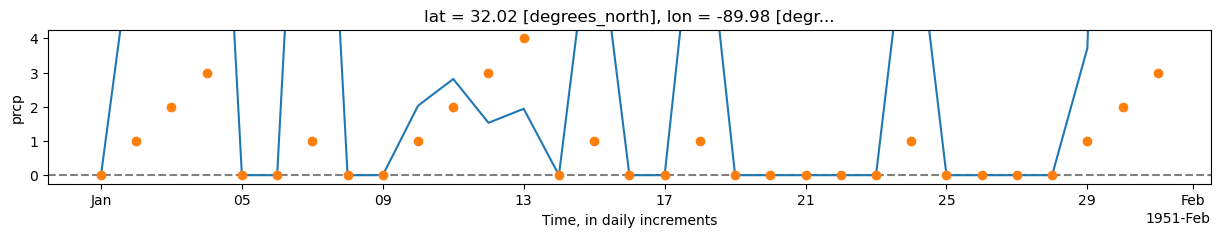

In [11]:
# let's see if it's really working
fig=plt.figure(figsize=(15,2))
plt.axhline(y=0,color='grey',ls='dashed')  # threshold guide line
plt.ylim([-.25,4.25])
pr.sel(time=slice('1951-01-01','1951-01-31')).plot()
rr.sel(time=slice('1951-01-01','1951-01-31')).plot(marker='o',linewidth=0)

wow, ok it is working. blue line is daily precip, orange dots are the number of consecutive rain days.


# 3) Pnet

Approach based on Keetch & Byram 1968 description of Pnet calculation on their worksheet:

1) Categorize days: consecutive rain days (2), single rain days (1), no rain days (0)
2) Calculate Pnet on each day based on the category
    - category 0 (no rain): pnet = 0
    - category 1 (single rain day): pnet = max(pr - 0.2,0)  
    - category 2 (consecutive rain day): loop through events of consecutive rainfall days and
      
            - accumulate rainfall totals over consecutive days
            - on days before threshold is met (accumulated pr <= 0.2 inches): pnet = 0
            - on the exact day when the threshold is met: pnet = accumulated pr - 0.2 inches
            - on days after threshold is met: pnet = pr 

In [12]:
# categorize rainfall days: consecutive rain days (2), single rain days (1), no rain days (0)

# first swap out the time coordinate for the time_index
rr_swap = rr.swap_dims({'time':'time_index'})

# label all days that are at least the 3rd consecutive rainfall day with a 5
cat=xr.where(rr_swap>=3,5,rr_swap)

# find the indexes of all second consecutive rainfall days
consec_day2 = np.argwhere(rr_swap.data==2).flatten()

# find the indexes of all the first consecutive rainfall days
consec_day1 = consec_day2-1

# label all consecutive rainfall days with a 2 
cat[consec_day2]=5 # first put a 5
cat[consec_day1]=5 # first put a 5
cat = xr.where(cat==5,2,cat) # convert to 2's

# should be left with only 2's (consecutive rain days), 1's (single rain days), and 0's (no rain days)
np.unique(cat)

array([0., 1., 2.])

In [13]:
# Calc Pnet 

acc_thresh = 5.08 # mm

# Category 0 (no rain days)
# pnet will be zero where pr is zero
pnet = pr.swap_dims({'time':'time_index'})

# Category 1 (single rain days)
pnet = xr.where(cat==1,pnet-acc_thresh,pnet)
pnet = xr.where(pnet<0,0,pnet)
pnet

<xarray.DataArray 'prcp' (time_index: 1826)> Size: 7kB
array([ 0.  ,  7.73, 24.83, ...,  0.  ,  0.  ,  0.  ],
      shape=(1826,), dtype=float32)
Coordinates:
    time         (time_index) datetime64[ns] 15kB 1951-01-01 ... 1955-12-31
    lat          float32 4B 32.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0
  * time_index   (time_index) int64 15kB 0 1 2 3 4 ... 1821 1822 1823 1824 1825

In [14]:
# Category 2 (consecutive rain days) 

consec_inds = cat[cat==2].time_index

# initializations
thresh_flag=False
end_event=False
accpr=0. 

# loop through days in each multi-day rain event
for i,ind in enumerate(consec_inds):
    
    # accumulated precip per rain event
    accpr=accpr+pr[ind].item() 

    # if not over the threshold yet, Pnet is 0
    if accpr<=acc_thresh and not thresh_flag:
        pnet[ind]=0
        
    # on the day the threshold is met, subtract the threshold amount and change flag    
    elif accpr>acc_thresh and not thresh_flag:
        accpr=accpr-acc_thresh # accumulate precip and subtract threshold
        pnet[ind]=accpr
        thresh_flag=True
        
    # any days after the threshold is met, precip will remain unchanged
    else:
        pnet[ind]=pr[ind].item()     

    # reset accumulation and flag for the next consecutive rain event
    if i != len(consec_inds)-1:
        if (consec_inds[i+1] != consec_inds[i]+1): 
            accpr=0.
            thresh_flag=False
            
pnet

<xarray.DataArray 'prcp' (time_index: 1826)> Size: 7kB
array([ 0.  ,  2.65, 24.83, ...,  0.  ,  0.  ,  0.  ],
      shape=(1826,), dtype=float32)
Coordinates:
    time         (time_index) datetime64[ns] 15kB 1951-01-01 ... 1955-12-31
    lat          float32 4B 32.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0
  * time_index   (time_index) int64 15kB 0 1 2 3 4 ... 1821 1822 1823 1824 1825

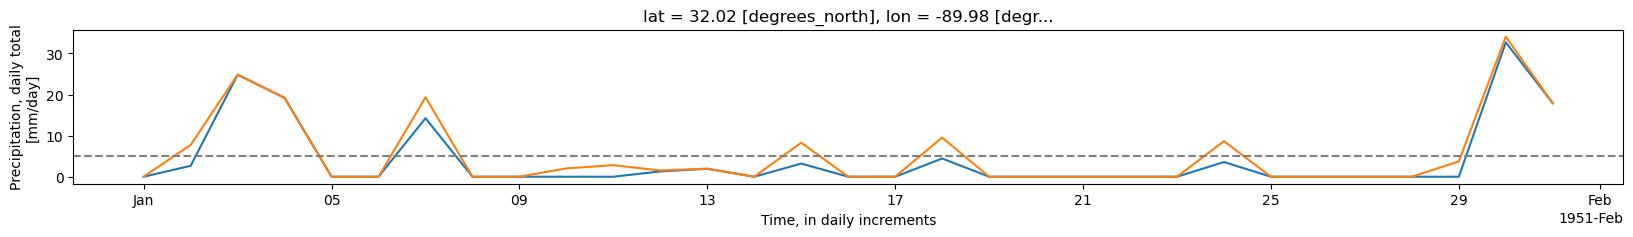

In [15]:
# compare pnet to pr to double check that everything worked correctly

pnet.swap_dims({'time_index':'time'}).sel(time='1951-01').plot(figsize=(20,2))
pr.sel(time='1951-01').plot()
plt.axhline(acc_thresh,color='grey',ls='dashed')
plt.show()

#### Looks correct


# 4) load tmax data and calc mean annual precip

In [16]:
# load 5 years of data at a single grid, limit precision per metadata, and convert units

tmax=xr.open_dataset(tmax_file).tmax.sel(time=slice(year_start,year_end)).sel(lat=lat,lon=lon, method='nearest').round(2).load()

# tmax = (tmax *9/5) + 32
# tmax_attrs = {'standard_name':'air_temperature','long_name':'Temperature, daily maximum','units':'F'}
# tmax.attrs = tmax_attrs

tmax

<xarray.DataArray 'tmax' (time: 1826)> Size: 7kB
array([10.73, 18.65, 18.69, ..., 17.65, 15.92, 11.45],
      shape=(1826,), dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 15kB 1951-01-01 1951-01-02 ... 1955-12-31
    lat          float32 4B 32.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0
Attributes:
    id:                /workspace/home2/home/imke.durre/active/live/products/...
    long_name:         Temperature, daily maximum
    valid_max:         100.0
    standard_name:     air_temperature
    naming_authority:  gov.noaa.ncei
    source:            GHCN-Daily CSV files 
    comment:           Values should be rounded to the nearest hundredth. Eac...
    units:             degree_Celsius
    reference:         https://doi.org/10.1175/JTECH-D-22-0024.1
    valid_min:         -100.0
    metadata_link:     https://doi.org/10.25921/c4gt-r169

# 4) Calculate KBDI 

## using SI units mm and C

$$
KBDI_{t} = Q_{t} + \frac{(203.2 - Q_{t}) (0.968 e^{0.0875 T_{t} + 1.5552} - 8.30) Δt}{1 + 10.88 e^{-0.001736 P}} * 10^{-3}
$$

$Q_{t}$ = $KBDI_{t-1}$ − $Pnet_{t}$

where: 

$KBDI_{t-1}$ is intialized to 0 everywhere at whatever time meets the wet condition criteria


In [17]:
# mean annual precip
mean_ann_pr = pr.groupby('time.year').sum(min_count=360).mean()
mean_ann_pr

<xarray.DataArray 'prcp' ()> Size: 4B
array(1259.846, dtype=float32)
Coordinates:
    lat          float32 4B 32.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0

In [18]:
# KBDI initialization

KBDI = np.full(pr.shape,np.nan) # set all to nan
KBDI[day_int]=0   # set to 0 at saturation day t-1

print(np.unique(KBDI))
KBDI.shape

[ 0. nan]


(1826,)

In [19]:
# KBDI calculation (mm, C)

denominator = 1 + 10.88 * np.exp(-0.001736*mean_ann_pr)

# looping through time
for it in range(day_int+1,KBDI.shape[0]):

    # KBDI calculation at every grid
    Q = KBDI[it-1] - pnet[it]
    numerator = (203.2 - Q) * (0.968 * np.exp(0.0875*tmax[it]+1.5552) - 8.3)
    KBDI[it] = Q + (numerator/denominator)*10E-3
  
    del Q, numerator

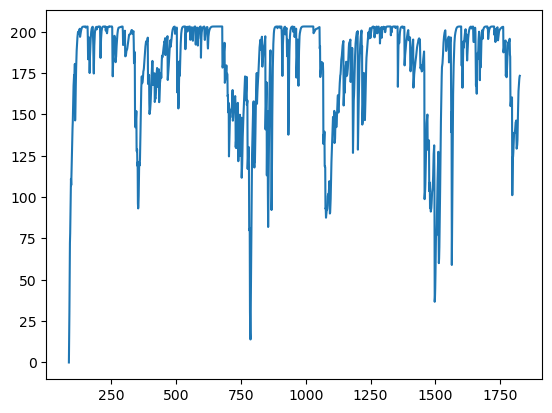

In [20]:
plt.plot(KBDI)